<a href="https://colab.research.google.com/github/LGN4Life/python/blob/master/LSTM_lgn_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pdb
import time

Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


load matlab file

In [0]:
mat_contents = sio.loadmat("/content/gdrive/My Drive/python/matlab files/example_mon_pair.mat")

In [0]:
type(mat_contents)
#matlab structs are loaded as a dictionary

dict

In [0]:
mat_contents

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Nov 26 09:51:44 2019',
 '__version__': '1.0',
 'lgn_spikes': array([[1.3547000e+00],
        [1.5136000e+00],
        [1.5157000e+00],
        ...,
        [2.3871325e+03],
        [2.3871503e+03],
        [2.3871824e+03]]),
 'rgc_spikes': array([[1.5111000e+00],
        [1.6172000e+00],
        [1.6289000e+00],
        ...,
        [2.3871731e+03],
        [2.3871919e+03],
        [2.3872027e+03]])}

In [0]:
lgn_spikes = mat_contents['lgn_spikes']
lgn_spikes = lgn_spikes[0:,0]
rgc_spikes = mat_contents['rgc_spikes']
type(lgn_spikes)

numpy.ndarray

create histogram of spiking data

In [0]:
max_spike_time = lgn_spikes.max()+1

bin_size = .001


In [0]:
hist_x = np.arange(0,max_spike_time,bin_size)

In [0]:
lgn_spike_hist,hist_bins = np.histogram(lgn_spikes,hist_x,density=False)

In [0]:
sum(lgn_spike_hist==0)/len(lgn_spike_hist)

0.9765746496707537

code below comes from tensorflow Time series forecasting tutorial

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


In [0]:
def shape_data_for_model(data, learning_size, target_size):
  row_num = data.shape[0]-learning_size
  reshaped_data  = np.empty((row_num,learning_size))*np.nan
  data_labels = np.empty((row_num,1))*np.nan
  

  for row in range(data_labels.shape[0]):
    
    indices = np.array(range(row,row+learning_size))
    # Reshape data from (history_size,) to (history_size, 1)
    
    reshaped_data[row,:] = data[indices]
    data_labels[row] = data[indices[-1]+1]
    #plt.plot(data[indices])
    #plt.show()
    #input("Press Enter to continue...")
    
  return reshaped_data, data_labels

In [0]:
TRAIN_SPLIT = np.floor(lgn_smooth_hist.size/2)

In [0]:
TRAIN_SPLIT=TRAIN_SPLIT.astype('int64')
#can't use floats as a slice, so converted to int64

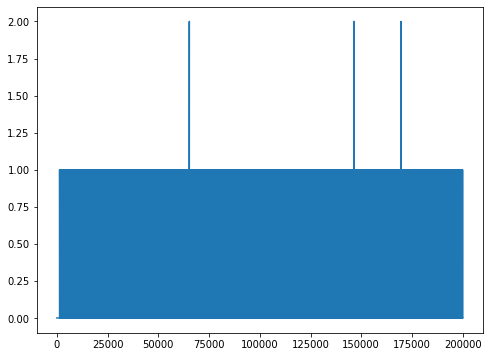

In [0]:
plt.plot(lgn_spike_hist[1:200000])

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [0]:
univariate_past_history = 250
univariate_future_target = 0

x_train_uni, y_train_uni = shape_data_for_model(lgn_spike_hist[0:TRAIN_SPLIT],
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = shape_data_for_model(lgn_spike_hist[TRAIN_SPLIT:],
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
#model needs 3d input, I think this will work
x_train_uni = x_train_uni[:,:,None]
x_val_uni = x_val_uni[:,:,None]


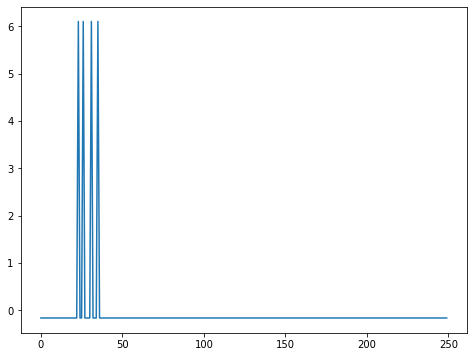

In [0]:
plt.plot(x_train_uni[100000,:])

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  print(time_steps)
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    #pdb.set_trace()
    #print(x)
    if i:
      #print(i)
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
      #print('do nothing' + ' ' + str(i))
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [0]:
def baseline(history):
  return np.mean(history)

# **Basic mechanics**

To create an input pipeline, you must start with a data source. For example, to construct a Dataset from data in memory, you can use tf.data.Dataset.from_tensors() or **tf.data.Dataset.from_tensor_slices()**. Alternatively, if your input data is stored in a file in the recommended TFRecord format, you can use tf.data.TFRecordDataset().

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
tf.random.uniform([4, 10])

<tf.Tensor: shape=(4, 10), dtype=float32, numpy=
array([[0.8016418 , 0.5604855 , 0.49106228, 0.05377293, 0.02989674,
        0.8228407 , 0.3150339 , 0.54276323, 0.9614556 , 0.6616738 ],
       [0.03499424, 0.31867862, 0.16091442, 0.53061736, 0.6445123 ,
        0.15656865, 0.98931074, 0.19575846, 0.2617767 , 0.5649947 ],
       [0.46816027, 0.5114094 , 0.02032852, 0.02349281, 0.93570065,
        0.10419619, 0.80288804, 0.16733575, 0.46961224, 0.82494473],
       [0.1726346 , 0.15376472, 0.9915637 , 0.3873204 , 0.39686048,
        0.76466906, 0.60434985, 0.1895436 , 0.9568486 , 0.14901412]],
      dtype=float32)>

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [0]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 28ms/step - loss: 0.1740 - val_loss: 0.1737
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1657 - val_loss: 0.1738
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1651 - val_loss: 0.1734
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1676 - val_loss: 0.1739
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1632 - val_loss: 0.1733
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1647 - val_loss: 0.1737
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1624 - val_loss: 0.1736
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1586 - val_loss: 0.1734
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1553 - val_loss: 0.1743
Epoch 10/10
200/200 [===========================

[-250, -249, -248, -247, -246, -245, -244, -243, -242, -241, -240, -239, -238, -237, -236, -235, -234, -233, -232, -231, -230, -229, -228, -227, -226, -225, -224, -223, -222, -221, -220, -219, -218, -217, -216, -215, -214, -213, -212, -211, -210, -209, -208, -207, -206, -205, -204, -203, -202, -201, -200, -199, -198, -197, -196, -195, -194, -193, -192, -191, -190, -189, -188, -187, -186, -185, -184, -183, -182, -181, -180, -179, -178, -177, -176, -175, -174, -173, -172, -171, -170, -169, -168, -167, -166, -165, -164, -163, -162, -161, -160, -159, -158, -157, -156, -155, -154, -153, -152, -151, -150, -149, -148, -147, -146, -145, -144, -143, -142, -141, -140, -139, -138, -137, -136, -135, -134, -133, -132, -131, -130, -129, -128, -127, -126, -125, -124, -123, -122, -121, -120, -119, -118, -117, -116, -115, -114, -113, -112, -111, -110, -109, -108, -107, -106, -105, -104, -103, -102, -101, -100, -99, -98, -97, -96, -95, -94, -93, -92, -91, -90, -89, -88, -87, -86, -85, -84, -83, -82, -81

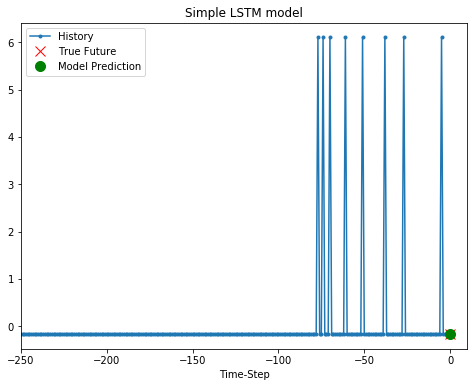

[-250, -249, -248, -247, -246, -245, -244, -243, -242, -241, -240, -239, -238, -237, -236, -235, -234, -233, -232, -231, -230, -229, -228, -227, -226, -225, -224, -223, -222, -221, -220, -219, -218, -217, -216, -215, -214, -213, -212, -211, -210, -209, -208, -207, -206, -205, -204, -203, -202, -201, -200, -199, -198, -197, -196, -195, -194, -193, -192, -191, -190, -189, -188, -187, -186, -185, -184, -183, -182, -181, -180, -179, -178, -177, -176, -175, -174, -173, -172, -171, -170, -169, -168, -167, -166, -165, -164, -163, -162, -161, -160, -159, -158, -157, -156, -155, -154, -153, -152, -151, -150, -149, -148, -147, -146, -145, -144, -143, -142, -141, -140, -139, -138, -137, -136, -135, -134, -133, -132, -131, -130, -129, -128, -127, -126, -125, -124, -123, -122, -121, -120, -119, -118, -117, -116, -115, -114, -113, -112, -111, -110, -109, -108, -107, -106, -105, -104, -103, -102, -101, -100, -99, -98, -97, -96, -95, -94, -93, -92, -91, -90, -89, -88, -87, -86, -85, -84, -83, -82, -81

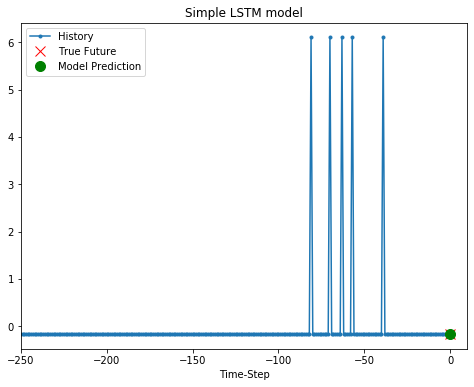

[-250, -249, -248, -247, -246, -245, -244, -243, -242, -241, -240, -239, -238, -237, -236, -235, -234, -233, -232, -231, -230, -229, -228, -227, -226, -225, -224, -223, -222, -221, -220, -219, -218, -217, -216, -215, -214, -213, -212, -211, -210, -209, -208, -207, -206, -205, -204, -203, -202, -201, -200, -199, -198, -197, -196, -195, -194, -193, -192, -191, -190, -189, -188, -187, -186, -185, -184, -183, -182, -181, -180, -179, -178, -177, -176, -175, -174, -173, -172, -171, -170, -169, -168, -167, -166, -165, -164, -163, -162, -161, -160, -159, -158, -157, -156, -155, -154, -153, -152, -151, -150, -149, -148, -147, -146, -145, -144, -143, -142, -141, -140, -139, -138, -137, -136, -135, -134, -133, -132, -131, -130, -129, -128, -127, -126, -125, -124, -123, -122, -121, -120, -119, -118, -117, -116, -115, -114, -113, -112, -111, -110, -109, -108, -107, -106, -105, -104, -103, -102, -101, -100, -99, -98, -97, -96, -95, -94, -93, -92, -91, -90, -89, -88, -87, -86, -85, -84, -83, -82, -81

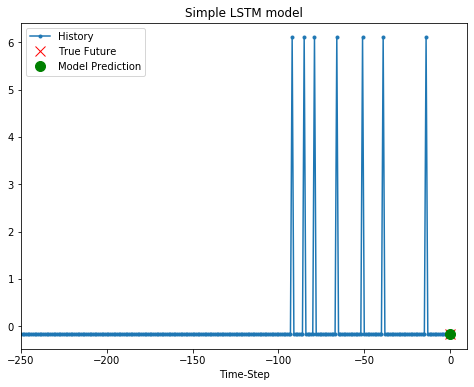

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [0]:
data_y = np.zeros((1000,))
predicted_y = np.zeros((1000,))
index=0;
for x, y in val_univariate.take(1000):
  
  data_y[index] = y[0].numpy()
  predicted_y[index] = simple_lstm_model.predict(x)[0]
  
  index+=1
  # plot = show_plot([x[0].numpy(), y[0].numpy(),
  #                   simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  # plot.show()


In [0]:
predicted_y.shape

(1000,)

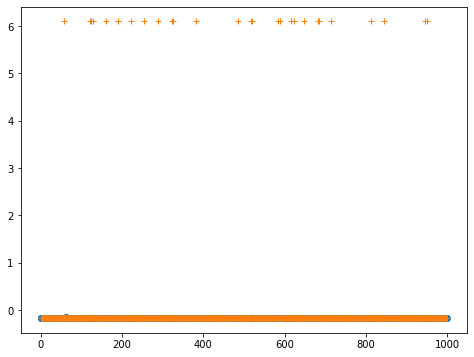

In [0]:

plt.plot(predicted_y,'o')
plt.plot(data_y,'+')


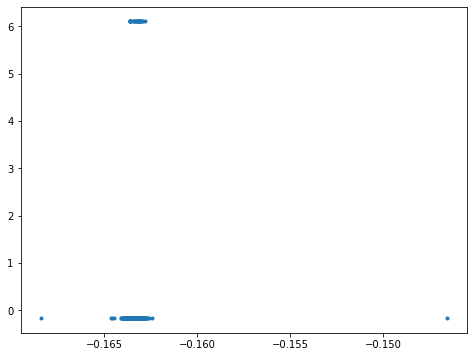

In [0]:
plt.plot(predicted_y,data_y,'.')

In [0]:
np.corrcoef(predicted_y,data_y)

array([[ 1.        , -0.02261393],
       [-0.02261393,  1.        ]])